In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Device configuration (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
# Ruta donde se almacenarán los datos CelebAGaze
root = 'datasets/CelebAGaze'

class EnsureRGBChannels:
    def __call__(self, image):
        if image.mode != 'RGB':
            image = image.convert('RGB')
        return image

# Transformaciones de datos
transform = transforms.Compose([
        EnsureRGBChannels(),
        transforms.Resize((128 , 128)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.flatten()),
        transforms.Lambda(lambda x: x * 2.0 - 1.0)
])

# Cargar datos de entrenamiento
train = ImageFolder(root=root, transform=transform)

In [3]:
train

Dataset ImageFolder
    Number of datapoints: 20000
    Root location: datasets/CelebAGaze
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Lambda()
               Lambda()
           )

In [4]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True) # type: ignore

imgs, _ = next(iter(dataloader))
imgs.shape

torch.Size([32, 49152])

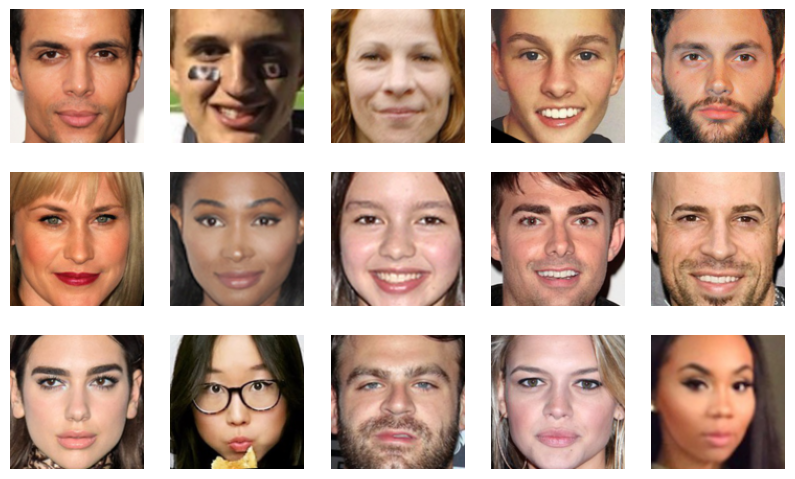

In [5]:
import random
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(train)-1)
        img, lab = train[ix]
        ax.imshow(img.reshape(3,128,128).permute(1,2,0)*0.5+0.5)
        ax.axis('off')
plt.show()

In [38]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, channel=1):
        super(Generator, self).__init__()
        self.channel = channel
        self.init_size = 128 // 4
        self.input_size = 100
        self.l1 = nn.Sequential(nn.Linear(self.input_size, 256 * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, self.channel, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 256, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        img = img.view(img.size(0), self.channel*128*128)
        return img

In [45]:
generator = Generator(channel=3)
output = generator(torch.randn(32, 100))
output.shape

torch.Size([32, 49152])

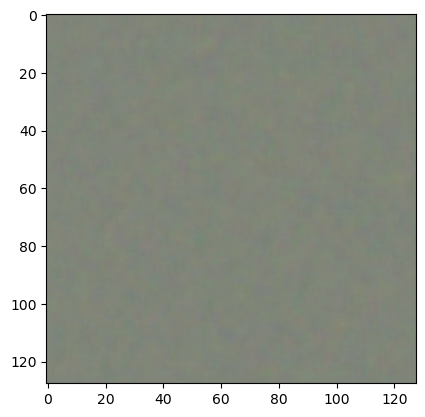

In [46]:
plt.imshow(output[0].view(3,128,128).permute(1,2,0).detach().numpy()*0.5+0.5)
plt.show()

In [49]:
import torchvision.models as models

class Discriminator(nn.Module):
  def __init__(self, channel):
    super().__init__()
    self.channel = channel
    # descargamos resnext
    resnext = models.resnext50_32x4d(weights=models.resnet.ResNeXt50_32X4D_Weights.DEFAULT)
    # nos quedamos con todas las capas menos la última
    self.resnext = nn.Sequential(*list(resnext.children())[:-1])
    for param in self.resnext.parameters():
      param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = nn.Linear(2048, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = x.view(x.size(0), self.channel, 128, 128)
    x = self.resnext(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    y = self.sigmoid(x)
    return y

  def unfreeze(self):
    for param in self.resnext.parameters():
      param.requires_grad = True

In [55]:
discriminator = Discriminator(channel=3)
output = discriminator(torch.randn(32, 3*128*128))
output.shape

torch.Size([32, 1])

In [56]:
# comprobar que los pesos del modelo resnext se hayan descargado correctamente
for name, param in discriminator.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name}, Shape: {param.shape}, Mean Value: {param.mean().item()}, Std Dev: {param.std().item()}")

Layer: fc.weight, Shape: torch.Size([1, 2048]), Mean Value: -0.00010187285079155117, Std Dev: 0.012733706273138523
Layer: fc.bias, Shape: torch.Size([1]), Mean Value: 0.021811535581946373, Std Dev: nan


In [12]:
isinstance(discriminator, Discriminator)

True

In [13]:
from matplotlib.dates import epoch2num
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=5, lr=3e-4):
    g.to(device)
    d.to(device)
    g_optimizer = torch.optim.Adam(g.parameters(), lr=lr)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=lr)
    crit = nn.BCELoss()
    g_loss, d_loss = [], []
    mb = master_bar(range(1, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}
    for epoch in mb:
        if isinstance(d, Discriminator) and epoch == 5:
            d.unfreeze()
        for X, y in progress_bar(dataloader, parent=mb):
            X, y = X.to(device), y.to(device)
            # entrenamos el discriminador
            g.eval()
            d.train()
            # generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            genenerated_images = g(noise)
            # input del discrminator
            d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
            # gorund truth para el discriminator
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
            # optimización
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())
            # entrenamos el generador
            g.train()
            d.eval()
            # generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            genenerated_images = g(noise)
            # salidas del discriminador
            d_output = d(genenerated_images)
            # gorund truth para el generator
            g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
            # optimización
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())
            # logs
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))
        
        torch.save(g.state_dict(), 'generator_v' + str(epoch) + '.pth')
        torch.save(d.state_dict(), 'discriminator_v' + str(epoch) + '.pth')
    return hist

In [57]:
hist = fit(generator, discriminator, dataloader, epochs=2, lr=1e-3)

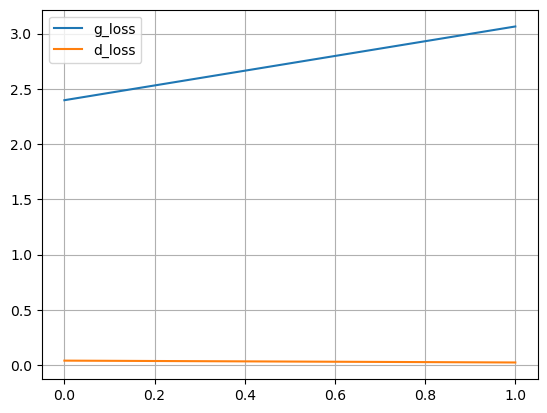

In [58]:
import pandas as pd

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

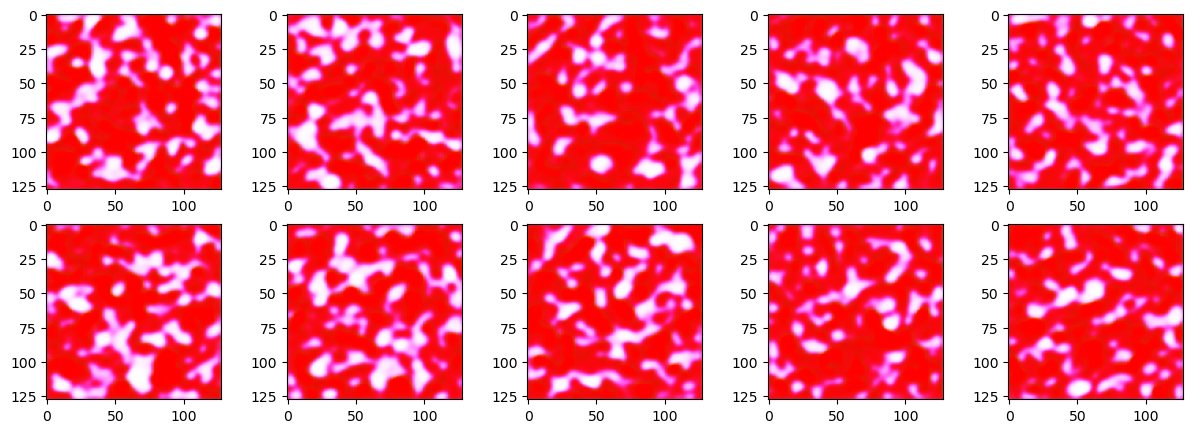

In [59]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = (generated_images[i].view(3,128,128).permute(1,2,0).cpu())*0.5+0.5
      _ax.imshow(img)
      i+=1
  plt.show()

In [ ]:
# guardar modelo entrenado
torch.save(generator.state_dict(), 'color_generator.pth')

In [ ]:
# cargar modelo entrenado
generator = Generator(channel=3)
generator.load_state_dict(torch.load('color_generator.pth'))

In [ ]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = (generated_images[i].view(3,128,128).permute(1,2,0).cpu())*0.5+0.5
      _ax.imshow(img)
      i+=1
  plt.show()